In [1]:
# Imports
import time
import re
from tqdm import tqdm
import os
import sys
import math
from sklearn.model_selection import cross_validate
from pprint import pprint as pp
import time
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import csv
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten,Dropout ,MaxPooling2D, BatchNormalization
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from sklearn.metrics import accuracy_score ,precision_score,confusion_matrix, recall_score
sys.path.append('../..') #add root directory of project to import needed modules

from src.train_model import train_model
from src.evaluate_model import evaluate_model
from src.utils.general import load_yaml, save_yaml
from src.utils.metrics import compute_metrics
from src.utils.pipeline import load_model, build_data_loader, freeze_layers
from src.utils.post_processing import aggregate_detailed_classes, aggregate_obj_results
from src.analysis.mistakes import show_mistakes_by_target, show_mistakes_by_pred, plot_proba_distr
from IPython.display import clear_output

from src.collection import CollectionAttention, CollectionSeparate
from src.models.densenet import densenet121, DenseNetAttn
from src.models.efficeintnet import EfficientnetB3AttnPretrained, EfficientnetB3Pretrained, EfficientnetB3
from src.models.mobilenet import MobileNetV2_
from src.models.resnet import ResNet50
from src.train import TrainerAttention, TrainerSeparate

from etc.alrosa.utils import get_values
from sklearn.svm import SVC
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipyfilechooser import FileChooser
 # Disable warnings print
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
def create_buttons():
    global path
    buttons=[]
    for foldername in os.listdir(path): 
            button1 = widgets.Button(description=str(foldername), 
                        button_style='success',
                                     layout=widgets.Layout(width='100px', height='80px')
                        )
            buttons.append(button1)         
    return buttons
layout_hidden  = widgets.Layout(visibility = 'hidden')
def on_y_clicked(b) :
    global path ,desc ,images
    path+='/'+desc
    clear_output(wait=True)
    print('Датасет успешно выбран.')
    images=forming_csv(path)
def on_n_clicked(b) :
    clear_output(wait=True)
    print('Перезапустите модуль')
def button_learn_click(b):
    start_learning_menu()

In [3]:
def start_menu():
    clear_output(wait=True)
    global path,model
    print('Путь к датасету', path)
    if(model) :
        print('Обученная модель существует')
        button_def = widgets.Button(description='Перейти к распознаванию', 
                        button_style='success' # 'success', 'info', 'warning', 'danger', ''
                    )
        display(button_def)
        button_def.on_click(skip_learning)
    else :
        print('Обученной модели нет')
    button_learn = widgets.Button(description='Обучить программу', 
                        button_style='success' # 'success', 'info', 'warning', 'danger', ''
                    )
    display(button_learn)
    button_learn.on_click(button_learn_click)

In [4]:
def on_button_clicked(b): 
    global path ,desc
    temp_path='C:/Users/getbb/Documents/classification_pipeline/images'
    desc = b.description
    temp_path+='/'+str(b.description)
    j=0
    pic_box = plt.figure(figsize=(16,4))
    for foldername in os.listdir(temp_path): 
        i=0
        for names in glob.glob(os.path.join(temp_path+'/'+foldername, '*.jpg')):
            names=names.replace("\\",'/')
            if i==0 :
                image = cv2.imread(names)
                pic_box.add_subplot(2,5,j+1)
                j+=1
                plt.imshow(image)
                i+=1
    plt.show()
    print('Это желаемый датасет?')
    button3 = widgets.Button(description='Да', 
                        button_style='success' # 'success', 'info', 'warning', 'danger', ''
                        )
    button4 = widgets.Button(description='Нет', 
                        button_style='danger' # 'success', 'info', 'warning', 'danger', ''
                        )
    button3.on_click(on_y_clicked)
    button4.on_click(on_n_clicked)
    display(button3)
    display(button4)
def start_learning_menu() :
    print('Выберите датасет')
    buttons = create_buttons()
    for i in range(len(buttons)):
        display(buttons[i])
        buttons[i].on_click(on_button_clicked)
    return


In [5]:
def click_b(b):
    clear_output(wait=True)
    learn_and_options()

In [6]:
def on_radio_choose(b):
    global method
    method = b['new']
def choose_method_menu() :
    print('Выберите метод распознавания :')
    radio=widgets.RadioButtons(
    options=['Метод опорных векторов','Полносвязная Нейронная Сеть', 'Сверточная Нейронная Сеть', 'ResNet50'],
    description=':',
    disabled=False)
    button = widgets.Button(description='Выбрать метод', 
                        button_style='success' # 'success', 'info', 'warning', 'danger', ''
                        )
    radio.observe(on_radio_choose, names='value')
    display(radio)
    button.on_click(click_b)
    display(button)
    

In [7]:
def save_settings_to_txt_file(parametrs):
    global method
    if method=='Метод опорных векторов' :
        with open("C:/Users/getbb/Documents/classification_pipeline/model/SVC.txt", "w") as file:
            file.write("Kernel:" +str(parametrs['kernel']))
    if method=='Полносвязная Нейронная Сеть' :
        with open("C:/Users/getbb/Documents/classification_pipeline/model/poln_neural_work.txt", "w") as file:
            file.write("optimizer:" +str(parametrs['optimizer'])+'\n')
            file.write("loss:" +str(parametrs['loss']))
    if method=='Свёрточная Нейронная Сеть' :
        with open("C:/Users/getbb/Documents/classification_pipeline/model/sv_neural_work.txt", "w") as file:
            file.write("optimizer:" +str(parametrs['optimizer'])+'\n')
            file.write("loss:" +str(parametrs['loss']))
    if method=='ResNet50' :
        with open("C:/Users/getbb/Documents/classification_pipeline/model/ResNet50.txt", "w") as file:
            file.write("optimizer:" +str(parametrs['optimizer'])+'\n')
            file.write("loss:" +str(parametrs['loss']))

In [8]:
def find_face():
    cascadePath = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    faceCascade = cv2.CascadeClassifier(cascadePath)
    for i in range (len(images)):
        img = cv2.imread(images['img_path'][i])
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = faceCascade.detectMultiScale(gray,  scaleFactor=1.2, minNeighbors=5,minSize=(20, 20)  )
        if (len(faces)>0) :
            for (x, y, w, h) in faces:
                face=gray[y: y + h, x: x + w]
                resize_face=cv2.resize(face, (224,224))
                path="onlyfaces/"+str(i)+".jpg"
                isWritten =cv2.imwrite(path,resize_face)
                images['img_path'][i]=path
    return
def load_and_split_data_s(data) :
    x_train=[]  
    y_train=[]
    x_test=[]
    y_test=[]
    seed=10
    gems = images.groupby(['obj_id'])['target'].first().reset_index()
    train_gems, test_gems = train_test_split(gems, stratify=gems['target'], test_size=0.16, random_state=seed)
    for i in range (len(images)):
        img = cv2.imread(images['img_path'][i])
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if(gray.shape[0]!=224) :
            continue
        if images['obj_id'][i] in train_gems['obj_id'] :
            x_train.append(gray)
            y_train.append(images['target'][i])
        else :
            x_test.append(gray)
            y_test.append(images['target'][i])
    return(np.asarray(x_train),np.asarray(y_train),np.asarray(x_test),np.asarray(y_test))
def as_row_matrix (X):
    if len (X) == 0:
        return np. array ([])
    mat = np. empty ((0 , X [0].size ), dtype =X [0]. dtype )
    for row in X:
        mat = np.vstack(( mat , np.asarray( row ).reshape(1 , -1))) # 1 x r*c
    return mat

In [9]:
def run_poln_NW():
    global images
    clear_output(wait=True)
    parametrs=read_params_from_file()
    find_face()
    x_train,y_train,x_test,y_test=load_and_split_data_s(images)
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    x_train = x_train.reshape(len(y_train), 50176)
    x_test = x_test.reshape(len(y_test), 50176)
    x_train = x_train.astype("float32")/255
    x_test = x_test.astype("float32")/255
    model = Sequential()
    model.add(Dense(350, input_dim=50176, activation='relu'))
    model.add(Dense(245))
    model.add(Dense(5,activation='softmax'))
    model.compile(optimizer=parametrs['optimizer'], loss=parametrs['loss'], metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=11, verbose=2, validation_data=(x_test, y_test))
    return model
    

In [10]:
def run_sc_NN() :
    global images
    clear_output(wait=True)
    parametrs=read_params_from_file()
    find_face()
    x_train,y_train,x_test,y_test=load_and_split_data_s(images)
    

In [11]:
def read_params_from_file():
    global method
    if method=='Метод опорных векторов' :
        with open("C:/Users/getbb/Documents/classification_pipeline/model/SVC.txt", "r") as file:
            mas=file.readlines()
            parametrs={}
            key_val=mas[0].split(':')
            parametrs[key_val[0]] = key_val[1]
    if method=='Полносвязная Нейронная Сеть' :
        with open("C:/Users/getbb/Documents/classification_pipeline/model/poln_neural_work.txt", "r") as file:
            mas=file.readlines()
            parametrs={}
            for i in range(len(mas)) :
                mas[i]=mas[i].rstrip()
                key_val=mas[i].split(':')
                parametrs[key_val[0]] = key_val[1]
    if method=='Свёрточная Нейронная Сеть' :
        with open("C:/Users/getbb/Documents/classification_pipeline/model/neural_work.txt", "r") as file:
            mas=file.readlines()
            parametrs={}
            for i in range(len(mas)) :
                mas[i]=mas[i].rstrip()
                key_val=mas[i].split(':')
                parametrs[key_val[0]] = key_val[1]
    if method=='ResNet50' :
        with open("C:/Users/getbb/Documents/classification_pipeline/model/ResNet50.txt", "r") as file:
            mas=file.readlines()
            parametrs={}
            for i in range(len(mas)) :
                mas[i]=mas[i].rstrip()
                key_val=mas[i].split(':')
                parametrs[key_val[0]] = key_val[1]
    return parametrs

In [12]:
def Run_SVC_with_params():
    global images
    clear_output(wait=True)
    parametrs=read_params_from_file()
    x_train,y_train,x_test,y_test=load_and_split_data(images)
    print('Модель обучается...')
    SVC_model = SVC(kernel= parametrs['Kernel'])
    SVC_model.fit(as_row_matrix(x_train), y_train)
    return SVC_model

In [13]:
def start_learning(b):
    global method,model
    if method=='Метод опорных векторов' :
        model=Run_SVC_with_params()
        clear_output(wait=True)
    if method=='Полносвязная Нейронная Сеть':
        model=run_poln_NW()
        clear_output(wait=True)
    if method=='Свёрточная Нейронная Сеть':
        model=run_sv_NW()
        clear_output(wait=True)
    if method=='ResNet50':
        model=run_sv_NW()
        clear_output(wait=True)
    print('Обучение модели завершено')
    get_image_panel()


In [14]:
def skip_learning(b) :
    if model :
        get_image_panel()
    else :
        start_menu()
        print("Обученных моделей нет")

In [15]:
def get_image_panel():
    clear_output(wait=True)
    button = widgets.Button(description='Распознавание с камеры', 
                        button_style='success' # 'success', 'info', 'warning', 'danger', ''
                        ,layout=widgets.Layout(width='300px'))
    button1 = widgets.Button(description='Распознавание с изображения', 
                        button_style='success' # 'success', 'info', 'warning', 'danger', ''
                        ,layout=widgets.Layout(width='300px'))
    to_back_button = widgets.Button(description='Назад', 
                        button_style='danger')
    display(to_back_button)
    to_back_button.on_click(go_to_learn)
    display(button)
    button.on_click(web_camera)
    display(button1)
    button1.on_click(import_image)

In [16]:
def web_camera(b):
    cascadePath = "C:/Users/getbb/anaconda3/Lib/site-packages/cv2/data/haarcascade_frontalface_default.xml"
    faceCascade = cv2.CascadeClassifier(cascadePath)
    cap = cv2.VideoCapture(0)
    cap.set(cv2.CAP_PROP_FPS, 24)
    arr_faces=[]
    j=0
    while j<1 :
        ret, img = cap.read()
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = faceCascade.detectMultiScale(gray,scaleFactor=1.2,minNeighbors=5,minSize=(20, 20))
        for (x, y, w, h) in faces:
            face=gray[y: y + h, x: x + w]  
            resize_face=cv2.resize(face, (224,224))
            arr_faces.append(resize_face)
            as_arr=np.asarray(arr_faces)
            prediction=getNumberPredict(model.predict(as_row_matrix(as_arr)))
            cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
            plt.figure()
            plt.imshow(img)
            j+=1
            print('Человек определён',images.class_name.unique()[prediction])
    

In [17]:
def choose_kernel(b) :
    parametrs={'kernel':'None'}
    print('значение ядра ',b['new'])
    parametrs['kernel']=b['new']
    save_settings_to_txt_file(parametrs)

In [18]:
def go_to_image_panel(b) :
    get_image_panel()

In [19]:
def go_to_learn(b) :
    learn_and_options()

In [20]:
def click_on_options(b):
    global method
    clear_output(wait=True)
    if method== 'Метод опорных векторов':
        choose_opt=widgets.RadioButtons(
    options=['poly','linear','rbf','tanh'],
    description='Функция ядра:',style={'description_width': 'initial'})
        display(choose_opt)
        choose_opt.observe(choose_kernel,names='value')
    if (method == 'Полносвязная Нейронная Сеть') :
        choose_opt=widgets.RadioButtons(
    options=['Adam','SGD','Adagrad','RMSProp'],
    description='Отпимизатор:',style={'description_width': 'initial'})
        choose_opt2=widgets.RadioButtons(
    options=['categorical_crossentropy','sparse_categorical_crossentropy','cosine _proximity','Poisson'],
    description='Функция потерь:',style={'description_width': 'initial'})
        display(choose_opt)
        choose_opt.observe(choose_optimizer,names='value')
        choose_opt2.observe(choose_loss,names='value')
    to_back_button = widgets.Button(description='Назад', 
                        button_style='danger')
    if (method == 'Cвёрточная Нейронная Сеть') :
        choose_opt=widgets.RadioButtons(
    options=['Adam','SGD','Adagrad','RMSProp'],
    description='Отпимизатор:',style={'description_width': 'initial'})
        choose_opt2=widgets.RadioButtons(
    options=['categorical_crossentropy','sparse_categorical_crossentropy','cosine _proximity','Poisson'],
    description='Функция потерь:',style={'description_width': 'initial'})
        display(choose_opt)
        choose_opt.observe(choose_optimizer,names='value')
        choose_opt2.observe(choose_loss,names='value')
    to_back_button = widgets.Button(description='Назад', 
                        button_style='danger')
    if (method == 'ResNet50') :
        choose_opt=widgets.RadioButtons(
    options=['Adam','SGD','Adagrad','RMSProp'],
    description='Отпимизатор:',style={'description_width': 'initial'})
        choose_opt2=widgets.RadioButtons(
    options=['categorical_crossentropy','sparse_categorical_crossentropy','cosine _proximity','Poisson'],
    description='Функция потерь:',style={'description_width': 'initial'})
        display(choose_opt)
        choose_opt.observe(choose_optimizer,names='value')
        choose_opt2.observe(choose_loss,names='value')
    to_back_button = widgets.Button(description='Назад', 
                        button_style='danger')
    display(to_back_button)
    to_back_button.on_click(go_to_learn)
    
        

In [21]:
def choose_optimizer(b) :
    parametrs = read_params_from_file()
    parametrs['optimizer']=b['new']
    save_settings_to_txt_file(parametrs)
def choose_loss(b) :
    parametrs = read_params_from_file()
    parametrs['loss']=b['new']
    save_settings_to_txt_file(parametrs)

In [22]:
def learn_and_options() :
    clear_output(wait=True)
    button = widgets.Button(description='Обучение на существующей моделе', 
                        button_style='success' # 'success', 'info', 'warning', 'danger', ''
                        ,layout=widgets.Layout(width='300px'))
    button1 = widgets.Button(description='Настройка', 
                        button_style='success' # 'success', 'info', 'warning', 'danger', ''
                        ,layout=widgets.Layout(width='300px'))
    display(button)
    button.on_click(start_learning)
    button1.on_click(click_on_options)
    display(button1)
    

In [23]:
def forming_csv(path) :
    global classnames
    classnames=[]
    print('Ожидайте ,оформируется csv.файл')
    with open("C:/Users/getbb/Documents/classification_pipeline/samples/full.csv", mode="w", encoding='utf-8') as w_file :
            file_writer = csv.writer(w_file, delimiter = ",", lineterminator="\r")
            file_writer.writerow(["obj_id","class_name", "img_path", "target"])
            i=0
            j=-1
            for foldername in os.listdir(path): 
                classname=foldername
                for names in glob.glob(os.path.join(path+'/'+foldername, '*.jpg')):
                    names=names.replace("\\",'/')
                    if classname in classnames :
                        file_writer.writerow([i,classname,names,j])
                    else :
                        classnames.append(classname)
                        j+=1
                        file_writer.writerow([i,classname,names,j])
                    i+=1
    clear_output(wait=True)
    print('.csv Файл успешно создан по адресу','C:/Users/getbb/Documents/classification_pipeline/samples/full.csv')
    images = pd.read_csv('C:/Users/getbb/Documents/classification_pipeline/samples/full.csv')
    choose_method_menu()
    return images

In [24]:
def load_and_split_data(data) :
    print('Формируются данные...')
    x_train=[]  
    y_train=[]
    x_test=[]
    y_test=[]
    seed=10
    cascadePath = "C:/Users/getbb/anaconda3/Lib/site-packages/cv2/data/haarcascade_frontalface_default.xml"
    faceCascade = cv2.CascadeClassifier(cascadePath)
    gems = images.groupby(['obj_id'])['target'].first().reset_index()
    train_gems, test_gems = train_test_split(gems, stratify=gems['target'], test_size=0.16, random_state=seed)
    for i in range (len(images)):
        img = cv2.imread(images['img_path'][i])
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = faceCascade.detectMultiScale(gray,  scaleFactor=1.2, minNeighbors=5,minSize=(20, 20)  )
        if images['obj_id'][i] in train_gems['obj_id'] :
            for (x, y, w, h) in faces:
                face=gray[y: y + h, x: x + w]
                resize_face=cv2.resize(face, (224,224))
                x_train.append(resize_face)
                y_train.append(images['target'][i])
        else :
            for (x, y, w, h) in faces:
                face=gray[y: y + h, x: x + w]
                resize_face=cv2.resize(face, (224,224))
                x_test.append(resize_face)
                y_test.append(images['target'][i])
    return(np.asarray(x_train),np.asarray(y_train),np.asarray(x_test),np.asarray(y_test))   
def as_row_matrix (X):
    if len (X) == 0:
        return np. array ([])
    mat = np. empty ((0 , X [0].size ), dtype =X [0]. dtype )
    for row in X:
        mat = np.vstack(( mat , np.asarray( row ).reshape(1 , -1))) # 1 x r*c
    return mat

In [25]:
def import_image(b):
    global img_path,fc
    fc = FileChooser()
    fc.filter_pattern = '*.jpg'
    display(fc)
    button = widgets.Button(description='Выбрать фото', 
                        button_style='success' # 'success', 'info', 'warning', 'danger', ''
                    )
    display(button)
    button.on_click(detect_img)

In [26]:
def detect_img(b):  
    global img_path,fc
    img_path=fc.selected
    cascadePath = "C:/Users/getbb/anaconda3/Lib/site-packages/cv2/data/haarcascade_frontalface_default.xml"
    faceCascade = cv2.CascadeClassifier(cascadePath)
    img = cv2.imread(img_path)
    height, width, channels = img.shape
    print(height,width)
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (0,int(height*0.1))
    fontScale              = 4*(height*width)/(1300*827)
    fontColor              = (0,0,0)
    thickness              = 2
    lineType               = 2
    arr_faces=[]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray,scaleFactor=1.2,minNeighbors=5,minSize=(20, 20))
    for (x, y, w, h) in faces:
        face=gray[y: y + h, x: x + w]  
        resize_face=cv2.resize(face, (224,224))
        arr_faces.append(resize_face)
        as_arr=np.asarray(arr_faces)
        prediction=getNumberPredict(model.predict(as_row_matrix(as_arr)))
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
        plt.figure()
        plt.imshow(img)
        print("Лицо на картинке: ",images.class_name.unique()[prediction])

In [27]:
def getNumberPredict(predict) :
    prediction = max(predict[0])
    for i in range(len(predict[0])):
        if predict[0][i]==prediction :return i
    
    

In [28]:
model=''

In [29]:
font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (0,30)
fontScale              = 0.8
fontColor              = (0,0,0)
thickness              = 2
lineType               = 2


Button(button_style='danger', description='Назад', style=ButtonStyle())

Button(button_style='success', description='Распознавание с камеры', layout=Layout(width='300px'), style=Butto…

Button(button_style='success', description='Распознавание с изображения', layout=Layout(width='300px'), style=…

Человек определён Albov_NA


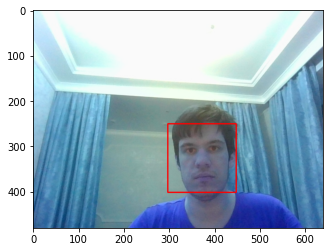

In [32]:
path='C:/Users/getbb/Documents/classification_pipeline/images'
desc = ''
start_menu()

In [31]:
images.head()

NameError: name 'images' is not defined